# Quantum Machine Learning

We include a callback function to make the post processing more extensive

In [3]:
import os
with open(os.path.expanduser('~')+"/Documents/keys/ibm-token.txt") as f:
    # Newline character must be excluded
    IBM_token = f.readline()[:-1]

In [4]:
# General imports
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", token=IBM_token)
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

In [2]:
service.backends()

NameError: name 'service' is not defined

In [6]:
backend = service.get_backend("ibmq_qasm_simulator")

# Step 1. Map classical inputs to a quantum problem
$
\hat{\mathcal{H}}\ =\ 0.3980 \mathcal{Y}\mathcal{Z} - 0.3980 \mathcal{Z}\mathcal{I} - 0.0113 \mathcal{Z}\mathcal{Z} + 0.1810 \mathcal{X}\mathcal{X}$

In [7]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [8]:
hamiltonian.num_qubits

2

There are different ways to choose the state vector or Ansatz wavefunction

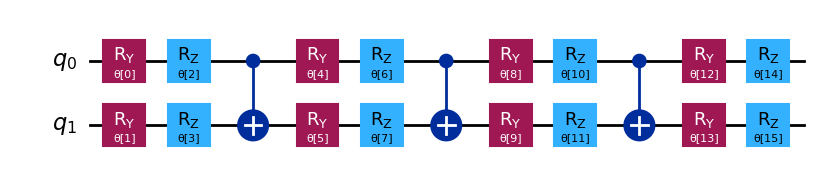

In [9]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [10]:
num_params = ansatz.num_parameters
num_params

16

# Step 2. Optimize problem for quantum execution

You don't need to optimize for simulator

#### The following code does not run if backend is a simulator

In [24]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
    ConstrainedReschedule,
)
from qiskit.circuit.library import XGate

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        PadDynamicalDecoupling(
            target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment
        ),
    ]
)

ansatz_ibm = pm.run(ansatz)

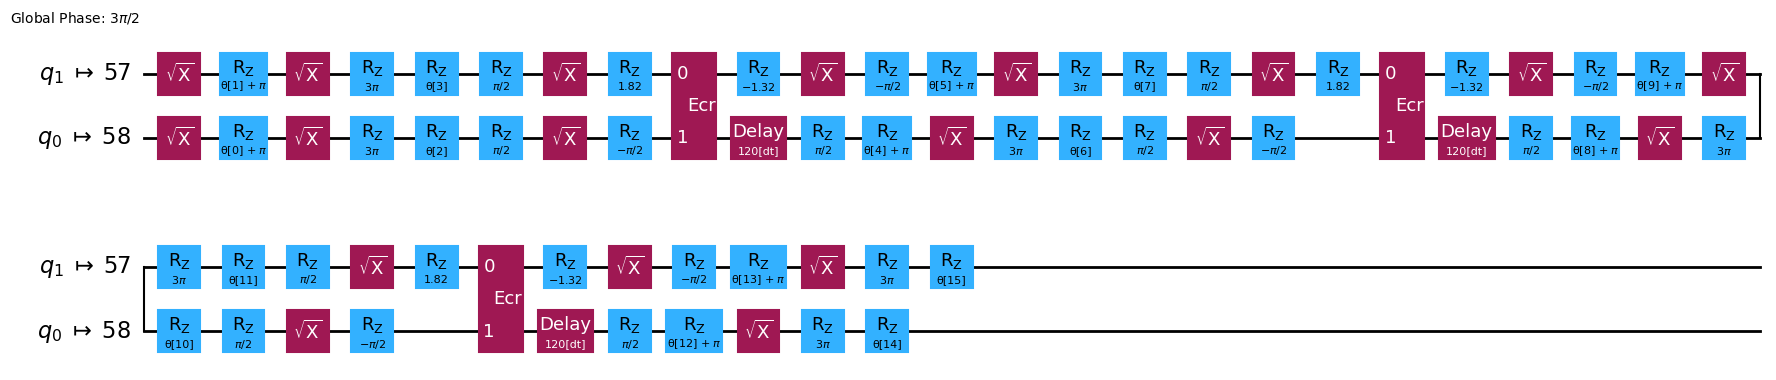

In [25]:
ansatz_ibm.draw(output="mpl", idle_wires=False, style="iqp")

In [26]:
ansatz_ibm.num_qubits

127

### We need to match the circuit qubit number with that of the hamiltonian

In [27]:
hamiltonian_ibm = hamiltonian.apply_layout(ansatz_ibm.layout)
hamiltonian_ibm

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZYIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[ 0.398 +0.j, -0.398 +0.j, -0.0113+0.j,  0.181 +0.j])

# Step 3.  Execute using Qiskit Primitives.

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

In [12]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

In [13]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [14]:
x0 = 2 * np.pi * np.random.random(num_params)

## In Simulator

In [15]:
from qiskit import transpile
ansatz=transpile(ansatz)

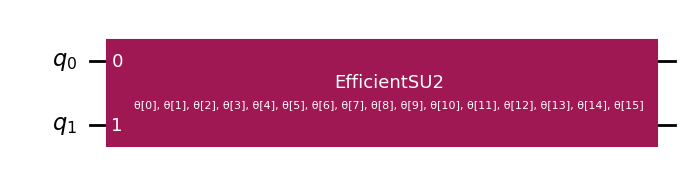

In [16]:
ansatz.draw(output="mpl")

In [17]:
# To run on local simulator:
#   1. Use the Estimator from qiskit.primitives instead.
#   2. Remove the Session context manager below.

from qiskit.primitives import Estimator

options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 1000

with Session(backend=backend):
    estimator = Estimator(options=options)
    callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
    res = minimize(
        cost_func,
        x0,
        args=(ansatz, hamiltonian, estimator),
        method="cobyla",
        callback=callback,
    )



TypeError: update_options() argument after ** must be a mapping, not Options

## In Real Quantum Computer

In [ ]:
    # To run on local simulator:
#   1. Use the Estimator from qiskit.primitives instead.
#   2. Remove the Session context manager below.

# options = Options()
# options.transpilation.skip_transpilation = True
# options.execution.shots = 10000

# with Session(backend=backend):
#     estimator = Estimator(options=options)
#     callback = build_callback(ansatz_ibm, hamiltonian_ibm, estimator, callback_dict)
#     res = minimize(
#         cost_func,
#         x0,
#         args=(ansatz_ibm, hamiltonian_ibm, estimator),
#         method="cobyla",
#         callback=callback,
#     )

In [ ]:
res

If you have to retrive result using jobid

# 4. Post Processing

In [ ]:
all(callback_dict["prev_vector"] == res.x)

In [ ]:
callback_dict["iters"] == res.nfev

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

Initialize set of parameters

In [10]:
jobid= "cqnv8pab9z30008m3cr0"
retrieved_job = backend.service.job(jobid)
retrieved_job.result()

EstimatorResult(values=array([-1.15950651]), metadata=[{'variance': 25.846076601201236, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192, 'warning': 'Optimization level clipped from 3 to 1'}])